Isotonic Regression
---------

### Introduction

According to Wikipedia[[1]](#refer-1), isotonic regression (also called monotonic regression) aims to fit a line that is non-decreasing (or non-increasing) everywhere, and lies as close to the a sequence of observations as possible. Notably, the fitted line has a free form. 

The isotonic regression is a important toolkit in application and machine learning. Two typical examples are given below.  

- Isotonic regression is suitable for fitting the dependence between medicine dose and toxicity,  for which we can expect that receiving more medicine dose would leads to a higher toxicity[[2]](#refer-2). 

- Isotonic regression is used in probabilistic classification to calibrate the predicted probabilities of supervised machine learning models[[3]](#refer-3).

### Example: noised log function

Below, we present a synthetic data example to see how to fit a isotonic regression with the `skscope` library. This synthetic example are drawn the model:

$$y = 2\log{(1 + x)} + \epsilon.$$

For simplicity, we let $x$ take value $0, 1, 2, \ldots, 499$ and let $\epsilon$s be i.i.d. observations drawn from standard normal distribution. The code for generating data are given as followed. 

In [40]:
import numpy as np
def gen_normal(n_step):
    y = 2 * np.log1p(np.arange(n_step)) + np.random.normal(size=n_step)
    return y

np.random.seed(0)
num = 500
y = gen_normal(num)

Here, we visualize the raw observations of $y$, and we can observe that the observations exhibit a monotonously increasing trend. 

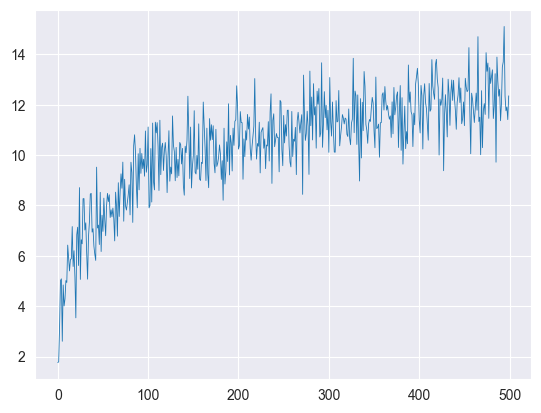

In [41]:
import matplotlib.pyplot as plt
plt.plot(y, label='raw observation', linewidth=0.6)

### Isotonic regression: a sparse-constrained optimization viewpoint

we use `skscope` to fit an isotonic regression with the raw observations. To this end, we formulate the isotonic regression as a sparse-constrained optimization:

$$\arg\min_{\beta} \sum_{i=1}^n (y_i - \sum_{j=1}^{i}|\beta_j| )^2 \; \textup{s.t.} \sum_{i=1}^n I(\beta_i \leq 0) \leq k,$$

where $\sum_{j=1}^{i}|\beta_j|$ returns a monotonic increasing sequence as $i$ grows up and $I(\beta_i \leq 0) \leq k$ controls the smoothness of regression model. If $k$ is large, then the fitted looks more smooth but it is more complicate, vice versa. 

Then, we give the implementation based on `skscope`. Notably, the implementation just comprises round 10 lines code. 

In [42]:
import jax.numpy as jnp
from skscope import ScopeSolver

def isotonic_regression(y, k):
    y = np.array(y)
    p = len(y)
    def custom_objective(params):
        return jnp.sum(jnp.square(y - jnp.cumsum(jnp.abs(params))))  
    solver = ScopeSolver(p, k)
    params = solver.solve(custom_objective)
    y_pred = np.cumsum(np.abs(params))   # give a isotonic fitting
    return y_pred

Then, we consider the isotonic regression results when $k = 10$ and $k = 100$. We also compare with the underlying function $2\log(1+x)$ and linear regression. 

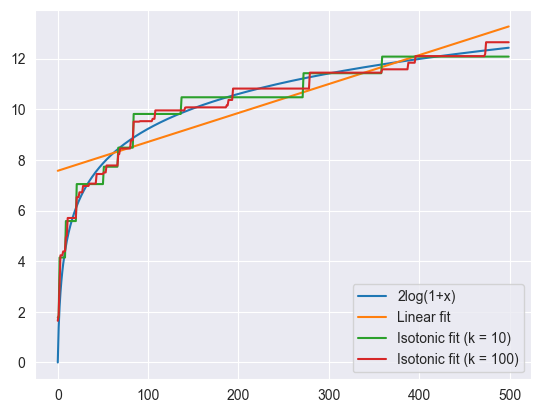

In [45]:
from sklearn.linear_model import LinearRegression

plt.plot(2 * np.log1p(np.arange(num)), label='2log(1+x)')
lr = LinearRegression()
x = np.linspace(1, num, num)[:, np.newaxis]
lr.fit(x, y)
plt.plot(lr.predict(x), label='Linear fit')
k = 10
plt.plot(isotonic_regression(y=y, k=k), label='Isotonic fit (k = {})'.format(k))
k = 100
plt.plot(isotonic_regression(y=y, k=k), label='Isotonic fit (k = {})'.format(k))
plt.legend()

From the Figure above, our implementation gives two lines that are closed to the blue curve. This implies the isotonic regression results based on `skscope` are reasonable estimations for the underlying function. In contrary, the linear regression largely deviates from the underlying function. 

### Extension: generalized isotonic regression

We can extend the isotonic regression to more general responses [[4]](#refer-4). For instance, 
we may change the loss function to a Huber loss:

$$
\text{Huber}(y_i, \sum_{j=1}^{i}|\beta_j|; M)=\left\{
\begin{aligned}
&(y_i - \sum_{j=1}^{i}|\beta_j|)^2, &|y_i - \sum_{j=1}^{i}|\beta_j||<M \\
&2M|y_i - \sum_{j=1}^{i}|\beta_j||-M^2, &|y_i - \sum_{j=1}^{i}|\beta_j||\geq M .\\
\end{aligned}
\right.
$$

to combat the outliers; or use the negative Poisson log-likelihood to analyze the counting response: 

$$\sum_{j=1}^{i}|\beta_j| - y_i \log(\sum_{j=1}^{i}|\beta_j|).$$

This change can easily cooperate with `skscope` to solve generalized isotonic regression.

### Reference

<div id="refer-1"></div>

- [1] Isotonic regression. https://en.wikipedia.org/wiki/Isotonic_regression

<div id="refer-2"></div>

- [2] Stylianou, Mario, and Nancy Flournoy. "Dose finding using the biased coin up‐and‐down design and isotonic regression." Biometrics 58.1 (2002): 171-177.

<div id="refer-3"></div>

- [3] Niculescu-Mizil, Alexandru, and Rich Caruana. "Predicting good probabilities with supervised learning." Proceedings of the 22nd international conference on Machine learning. 2005.

<div id="refer-4"></div>

 - [4] Luss, Ronny, and Saharon Rosset. "Generalized isotonic regression." Journal of Computational and Graphical Statistics 23.1 (2014): 192-210.